In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# ENGR2995 Practice Exam 1

### Guidelines for data plotting

When asked to produce a plot, you must:

1. Follow directions on whether to use a line plot or scatter plot
2. Provide descriptive labels for all axes and give units when indicated
3. Provide a descriptive title for the plot
4. Provide a descriptive legend for the plot when plotting more than one dataset
5. Use color or marker to differentiate between datasets when plotting more than one dataset

### Guidelines for report numerical and text-based answers

1. When asked to report a numerical value (e.g. a validation score), you must include a print statement that describes the value being reported either together or directly before the printing of the value itself.

2. When asked to answer a question with text, create a new text cell and answer the question in complete sentances.

## 1. Ridge Regression - Combined Cycle Power Plant

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE) of the plant.

Features consist of hourly average ambient variables
- Temperature (AT) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 millibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
- Net hourly electrical energy output (PE) 420.26-495.76 MW

The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

### Step 0: Load the dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
!unzip CCPP.zip

--2023-03-08 22:11:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3674852 (3.5M) [application/x-httpd-php]
Saving to: ‘CCPP.zip’

CCPP.zip            100%[===================>]   3.50M  --.-KB/s    in 0.08s   

2023-03-08 22:11:48 (42.4 MB/s) - ‘CCPP.zip’ saved [3674852/3674852]

Archive:  CCPP.zip
   creating: CCPP/
  inflating: CCPP/Folds5x2_pp.ods    
  inflating: CCPP/Folds5x2_pp.xlsx   
  inflating: CCPP/Readme.txt         
  inflating: CCPP/Readme.txt~        


In [ ]:
df = pd.read_excel('CCPP/Folds5x2_pp.xlsx')
df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


### Step 1: Visualize the dataset

**Construct a correlation heatmap plot**. Before plotting, do a basic check for missing values.

**Answer the following questions**:

1. What feature variable(s) have the highest correlation with the task variable (`PE`)?
2. What feature variable(s) have the lowest correlation with the task variable?
3. Are there any feature variables that are correlated to one-another i.e. r>0.5 or r<-0.5 (i.e. negative correlation)?

In [ ]:
# there was nothing in the problem statement about "placeholder" values like -200 or ?
# so, we can assume any missing values are NaN and drop them
df = df.dropna()

# printing the datatypes shows you whether any column contains non-numeric data
# since the datatypes are all numeric (float/int) they are good for modeling
print(df.dtypes)

AT    float64
V     float64
AP    float64
RH    float64
PE    float64
dtype: object


<AxesSubplot:>

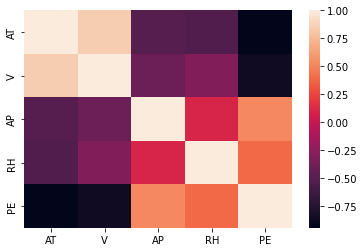

In [ ]:
sns.heatmap(df.corr())

In [ ]:
df.corr()

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


**Answer to text questions**
1. The variables with the highest correlation with `PE` are `AT` (ambient temperature) (r=-0.95) and `V` (exhaust vacuum pressure) (r=-0.87). Note that these variables are anti-correlated i.e. there is a high correlation between `PE` and the negative of `AT` (r=0.95).
2. The variable with the lowest correlation is `RH` (relative humidity) (r=0.39).
3. The variables `V` (r=0.84), `AP` (r=-0.51), and `RH` (r=-0.54) all show correlation with the variable `AT`.

### Step 2: Prepare the data for modeling

**Split the dataset into features (`X`) and task/labels (`y`). Split the features/labels into training and testing sets.** Include the `AT`, `V`, `AP`, and `RH` data as features.

In [ ]:
y = df['PE'].values
X = df.drop('PE', axis=1).values
print(X.shape, y.shape)

(9568, 4) (9568,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)

### Step 3: Hyperparameter optimization

1. **Construct a modeling `sklearn.pipeline.Pipeline` for fitting the data.** The pipeline should include:
  - `sklearn.preprocessing.PolynomialFeatures` polynomial feature expansion. Set the value of `degree` to 2.
  - `sklearn.preprocessing.StandardScaler` standardization transformation.
  - `sklearn.linear_model.Ridge` ridge regression model.
2. **Perform a grid search `GridSearchCV`** over
  - `alpha`: the regularization penalty strength parameter
3. **Print out the best cross-validation score and corresponding parameters.**

You may select the range of possible hyperparameter values, but you must compare at least 25 total models.

In [ ]:
model = Pipeline(steps=[('poly', PolynomialFeatures(2)), ('scale', StandardScaler()), ('ridge', Ridge())])
alpha = np.logspace(-4, 2)
params = {'ridge__alpha': alpha}
regr = GridSearchCV(model, params, return_train_score=True)
regr.fit(X_train, y_train)
print(f"Best Score: {regr.best_score_} Parameters: {regr.best_params_}")

Best Score: 0.9365297201128776 Parameters: {'ridge__alpha': 0.006866488450042998}


### Step 4: Complexity curve

**Construct a complexity curve showing the mean (1) training and (2) cross-validation score as a function of the `alpha` hyperparameter**. Plot (1) a scatter plot of `alpha` (x-axis) and the mean score, (2) a line plot of `alpha` and the mean score, and (3) error bars based on the mean and stdev of the mean score. Produce plots for both training and cross-validation score on the same graph. Be sure to follow all plotting guidelines (legend, axis labels, etc.).

**Comment on (1) the bias and (2) the variance as the complexity of model is decreased.**

[]

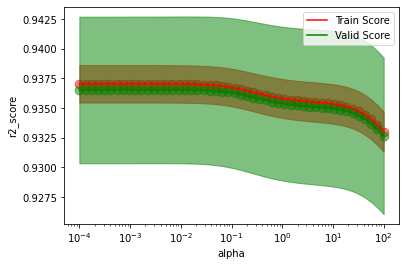

In [ ]:
train_means = regr.cv_results_['mean_train_score']
train_sems = regr.cv_results_['std_train_score']
valid_means = regr.cv_results_['mean_test_score']
valid_sems = regr.cv_results_['std_test_score']

plt.scatter(alpha, train_means, c='red', s=75, alpha=0.5)
plt.plot(alpha, train_means, c='red', label='Train Score')
plt.fill_between(alpha, train_means-train_sems, train_means+train_sems, color='red', alpha=0.5)

plt.scatter(alpha, valid_means, c='green', s=75, alpha=0.5)
plt.plot(alpha, valid_means, c='green', label='Valid Score')
plt.fill_between(alpha, valid_means-valid_sems, valid_means+valid_sems, color='green', alpha=0.5)

plt.xlabel('alpha')
plt.ylabel('r2_score')
plt.legend()
plt.semilogx()

**Answer to text question**

The model complexity is controlled by parameter alpha. At small values of alpha, the complexity is high. At large values of alpha, the complexity is low. The bias (the "incorrectness" of the model on the training set) is low at high values of complexity (alpha = 10e-4) and increases a small degree (small drop in r2 score from 0.9375 to 0.9350) as complexity is increased. The variance (as measured by the difference between train and valid scores) is small at all values of complexity.

### Step 5: Parity plot

**Construct a parity plot comparing the ground truth labels with the model predictions on the test set.** The parity plot should contain (1) a scatter plot showing the ground truth (x-axis) and predictions (y-axis) and (2) a parity line (or, a line where x=y). Be sure to follow all plotting guidelines. Be sure to retrain the best model with the entire training set before evaluating the test set.

In [ ]:
model = Pipeline(steps=[('poly', PolynomialFeatures(2)),
                        ('scale', StandardScaler()),
                        ('ridge', Ridge(regr.best_params_['ridge__alpha']))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Text(0.5, 1.0, 'Combined Cycle Power Plant Efficiency')

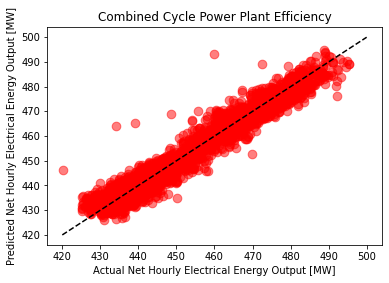

In [ ]:
plt.scatter(y_test, y_pred, c='red', s=75, alpha=0.5)
plt.plot([420, 500], [420, 500], ls='--', c='black')
plt.xlabel("Actual Net Hourly Electrical Energy Output [MW]")
plt.ylabel("Predicted Net Hourly Electrical Energy Output [MW]")
plt.title("Combined Cycle Power Plant Efficiency")

## 2. Logistic Regression - Diabetic Retinopathy

This dataset contains features extracted from the Messidor image set to predict whether an image contains signs of diabetic retinopathy, an eye condition that can cause vision loss and blindness in people who have diabetes. All features (columns `0` - `18`) represent either a detected lesion, a descriptive feature of a anatomical part or an image-level descriptor. The final column (`Class`) is the class label where 1 = contains signs of diabetic retinopathy and 0 = no sign of diabetic retinopathy.

### Step 0: Load the dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff

--2023-03-08 22:12:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117224 (114K) [application/x-httpd-php]
Saving to: ‘messidor_features.arff’

messidor_features.a 100%[===================>] 114.48K  --.-KB/s    in 0.03s   

2023-03-08 22:12:08 (3.87 MB/s) - ‘messidor_features.arff’ saved [117224/117224]



In [ ]:
from scipy.io.arff import loadarff
raw_data = loadarff('messidor_features.arff')
df = pd.DataFrame(raw_data[0]).astype({'Class': int})
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,Class
0,1.0,1.0,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1.0,0
1,1.0,1.0,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0.0,0
2,1.0,1.0,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0.0,1
3,1.0,1.0,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0.0,0
4,1.0,1.0,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,1.0,1.0,34.0,34.0,34.0,33.0,31.0,24.0,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0.0,0
1147,1.0,1.0,49.0,49.0,49.0,49.0,45.0,37.0,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0.0,0
1148,1.0,0.0,49.0,48.0,48.0,45.0,43.0,33.0,30.461898,13.966980,1.763305,0.137858,0.011221,0.000000,0.000000,0.000000,0.560632,0.129843,0.0,0
1149,1.0,1.0,39.0,36.0,29.0,23.0,13.0,7.0,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1.0,1


### Step 1: Prepare the data for modeling

1. **Prepare the target data `y` containing the data found in the `Class` column.**
2. **Prepare the design matrix `X` containing the data found in the remaining columns.** Be sure to drop the `Class` column before generating `X`.
3. **Split the dataset into training and testing sets.**

In [ ]:
y = df['Class'].values
X = df.drop('Class', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)

### Step 2: Hyperparameter optimization

1. **Construct a modeling `sklearn.pipeline.Pipeline` for fitting the data.** The pipeline should include:
  - `sklearn.preprocessing.PolynomialFeatures` polynomial feature expansion. Set the value of `degree` to 2.
  - `sklearn.preprocessing.StandardScaler` standardization transformation.
  - `sklearn.linear_model.LogisticRegression` logistic regression model.
2. **Perform a grid search `GridSearchCV`** over
  - `C`: the regularization penalty strength parameter
3. **Print out the best cross-validation score and corresponding parameters.**

You may select the range of possible hyperparameter values, but you must compare at least 25 total models.

In [ ]:
model = Pipeline(steps=[('poly', PolynomialFeatures(2)), ('scaler', StandardScaler()), ('logreg', LogisticRegression(penalty='l2', solver='liblinear'))])
C = np.logspace(-4, 2, 50)
parameters = {'logreg__C': C}
clf = GridSearchCV(model, parameters, return_train_score=True)
clf.fit(X_train, y_train)
print(f"Best Score: {clf.best_score_} Parameters: {clf.best_params_}")

Best Score: 0.764780212394139 Parameters: {'logreg__C': 1.0985411419875573}


### Step 3: Model testing and confusion matrix

Using the best model from step 2, retrain the model on the training set. **Generate a confusion matrix based on ground truth data and predictions of the model on the testing set. Identify the number of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) model predictions.**

In [ ]:
model = Pipeline(steps=[('poly', PolynomialFeatures(2)),
                           ('scaler', StandardScaler()),
                           ('logreg', LogisticRegression(C=clf.best_params_['logreg__C'], penalty='l2', solver='liblinear'))])
model.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=1.0985411419875573, solver='liblinear'))])

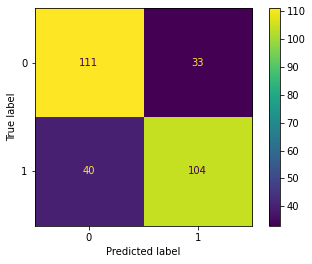

In [ ]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [ ]:
tn, fp, fn, tp = cm.flatten()
print(f"TP: {tp} TN: {tn} FP: {fp} FN: {fn}")

TP: 104 TN: 111 FP: 33 FN: 40


### Step 4: ROC Curve Interpretation

**Generate a receiver operator characteristic (ROC) curve based on the ground truth data and predictions of the model on the testing set. Calculate the area under the ROC curve (`roc_auc_score`) and display it on the graph or with a print statement.** Be sure that the resulting plot follows the plotting guidelines.

**We would like to calibrate the trained model such that we have a true positive rate of 90%. Estimate the resulting false positive rate.**

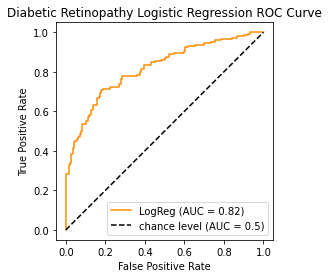

In [ ]:
from sklearn.metrics import RocCurveDisplay

# predict positive/negative probabilities
y_pred_proba = model.predict_proba(X_test)

# select probability of positive class
y_pred_pos_proba = y_pred_proba[:, 1]

RocCurveDisplay.from_predictions(
    y_test,
    y_pred_pos_proba,
    name=f"LogReg",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Diabetic Retinopathy Logistic Regression ROC Curve")
plt.legend()

We can estimate the false positivity rate at a given true positive rate by finding where the ROC curve intersects a horizontal line at the true positive rate. Then, we read off the x-value of that intersection to estimate the false positive rate. See below.

The estimated false positive rate is 0.6 or 60%.

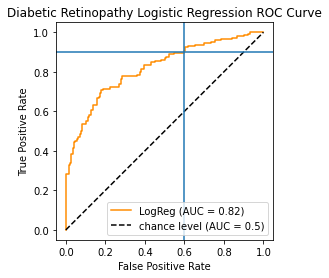

In [ ]:
RocCurveDisplay.from_predictions(
    y_test,
    y_pred_pos_proba,
    name=f"LogReg",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Diabetic Retinopathy Logistic Regression ROC Curve")
plt.legend()

# plotting a straight line at constant true positive rate = 0.9
plt.axhline(0.9)

# i adjusted the value of the vertical line so that it intersects the ROC curve and horizontal line
# the resulting value is the false positive rate
plt.axvline(0.6)

### Step 5: Model precision

**Compute the `precision_score` for the positive and negative classes based on the ground truth data and predictions of the model on the testing set. Comment on the how well we are able to trust positive classifications and negative classifications given by our model.**

In [ ]:
pos_prec = precision_score(y_test, y_pred, pos_label=1)
neg_prec = precision_score(y_test, y_pred, pos_label=0)
print(f"Positive Precision: {pos_prec} Negative Precision: {neg_prec}")

Positive Precision: 0.7591240875912408 Negative Precision: 0.7350993377483444


The precision gives the "predictive power" of our model i.e. what is the chance that a positive/negative classification is *actually* positive/negative.

When we predict a positive label, there is a 76% chance that the positive classification is accurate. When we predict a negative label, there is a 74% chance that the negative classification is accurate. So, on average, we can trust our classifications in 3 out of 4 examples.